### Gulf of Mexico Sea Surface Temperature and Chlorophyl Time Series Forecast Example

John Bonfardeci

Data thanks to NOAA (noaa.gov)

In [136]:
import sys, os
import math
import pandas as pd
import numpy as np
import pickle

from matplotlib import pyplot as plt
from matplotlib import axes
from matplotlib.figure import Figure
%matplotlib inline

import seaborn as sb

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.seasonal import seasonal_decompose, DecomposeResult

import pmdarima as pm
from pmdarima.arima import auto_arima, ARIMA
from pmdarima.arima.stationarity import ADFTest
from pmdarima.utils import check_exog

sys.path.append('../')

def get_mape(a, b):
    mask = a != 0
    mape = (np.fabs(a - b)/a)[mask].mean()
    mape = (-1)*mape if mape < 0 else mape
    print(f"MAPE: {round(mape*100,2)}%")
    return mape

def make_lags(X, lags=12, n_diffs=0):
    df = pd.DataFrame(columns=['lag_0'], data=X)
    if n_diffs > 0:
        df = df.diff(n_diffs).bfill()

    for lag in range(1, lags+1):
        df[f'lag_{lag}'] = X.shift(lag)

    return df.drop(labels=['lag_0'], axis=1).bfill()

def plot_lags(x, lags=12, n_diffs=0):
    df = make_lags(x, lags, n_diffs)
    _ = sb.pairplot(data=df, diag_kind='kde')

def standardize_residuals(residuals):
    e = np.array(residuals, dtype=float)
    mean = e.mean()
    std = e.std()
    return (e - mean)/std

def plot_figsize(plotted, w, h):
    fig: Figure = plotted.plot()
    fig.set_size_inches((w, h))
    fig.tight_layout()
    plt.show()

def evaluate_test_fit(model, y_test, X=None, indices=None):
    n_periods=len(y_test)
    yhat_test = model.predict(n_periods=n_periods, X=X)
    df_test = pd.DataFrame(
        data=[ [yhat,y,e,p] for (yhat,y,e,p) in zip( yhat_test, y_test, np.abs(y_test-yhat_test), np.abs(y_test-yhat_test)/y_test) ]
        , columns=['Yhat', 'Actual', 'Error', 'PercError']
    )
    if indices != None:
        df_test.index = indices

    display(df_test)
    print(f"MAE: {round(df_test.Error.mean(), 3)}, MAPE: {round(df_test.PercError.mean()*100, 2)}%")
    _ = df_test[['Yhat', 'Actual']].plot(figsize=(10, 5))

def plot_forecast(model, y_train, y_test, X=None, xticklabels=None):
    forecasts = model.predict(n_periods=len(y_test), X=X)
    fig = plt.figure(figsize=(25, 8))
    ax = fig.add_subplot(1, 1, 1)
    n_train = y_train.shape[0]
    x = np.arange(n_train + forecasts.shape[0])
    ax.plot(x[:n_train], y_train, color='blue', label='Training Data')
    ax.plot(x[n_train:], forecasts, color='green', label='Predicted') #marker='-', 
    ax.plot(x[n_train:], y_test, color='red', label='Actual')
    ax.legend(loc='lower left', borderaxespad=0.5)
    ax.set_title('Chlorophyll Levels')
    ax.set_ylabel('Chlorophyll Levels')
    if xticklabels != None:
        ax.set_xticklabels(xticklabels)
    plt.show()

def get_model(path, args, write_blob=True):
    if os.path.exists(path):
        with open(path, 'rb') as file:
            model = pickle.load(file)
    else:
        model = auto_arima(**args)
        if write_blob:
            with open(path, 'wb') as file:
                pickle.dump(model, file)

    return model

def get_outliers(X): 
    q1 = X.quantile(0.25)
    q3 = X.quantile(0.75)
    iqr = q3-q1
    outer_fence = (q1-3*iqr, q3+3*iqr)
    inner_fence = (q1-1.5*iqr, q3+1.5*iqr)
    probable = [x for x in X if x <= outer_fence[0] or x >= outer_fence[1]]
    possible = [x for x in X if (x <= inner_fence[0] or x >= inner_fence[1]) and (x > outer_fence[0] and x < outer_fence[1]) ]
    return possible, probable

## Import Sea Surface Temperature Data

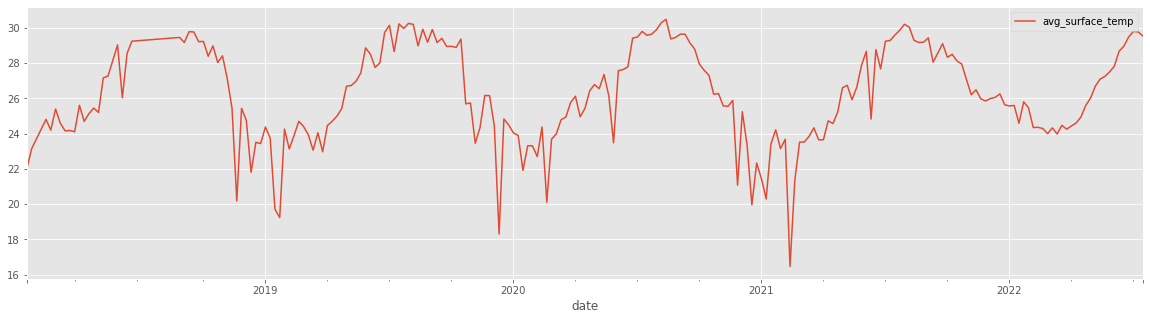

In [2]:
surface_temp = pd.read_csv('./data/avg_sea_surface_temp_weekly.csv')
surface_temp.index = pd.to_datetime(surface_temp.date)
surface_temp.drop(labels=['date'], axis=1, inplace=True)
# Impute missing values.
n = len(surface_temp)
surface_temp['avg_surface_temp'] = surface_temp['avg_surface_temp'].interpolate()
_ = surface_temp.plot(figsize=(20,5))

## Import Chlorophyll Data

<AxesSubplot:xlabel='date'>

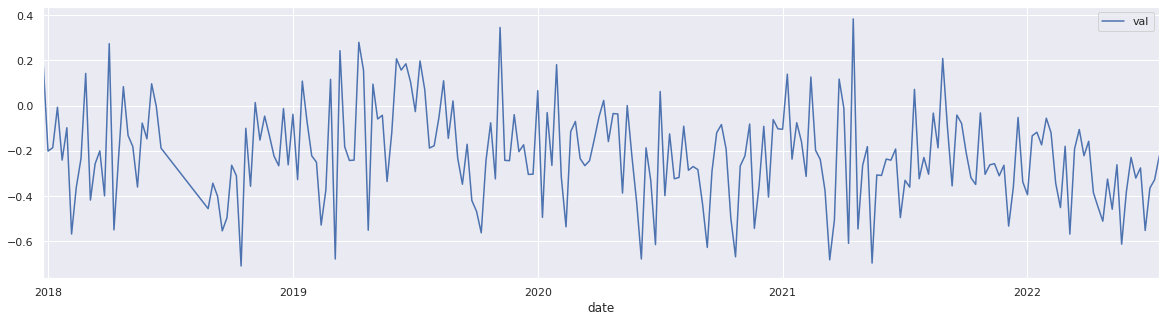

In [45]:
chlorophyll = pd.read_csv('./data/chlorophyll_weekly.csv')
chlorophyll.columns = ['date', 'val']
chlorophyll.index = pd.to_datetime(chlorophyll.date)
chlorophyll.drop(labels=['date'], inplace=True, axis=1)
# Impute missing values.
chlorophyll['val'] = chlorophyll['val'].interpolate()
chlorophyll.plot(figsize=(20,5))

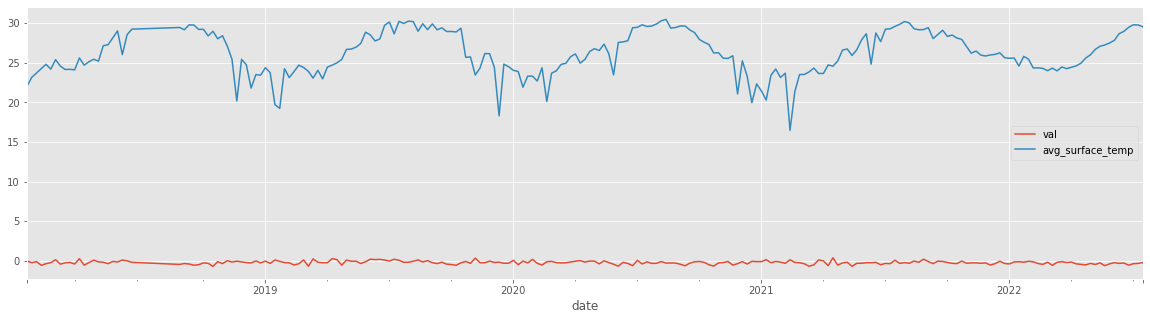

In [4]:
data = pd.merge(left=chlorophyll, right=surface_temp, left_index=True, right_index=True)
_ = data.plot(figsize=(20, 5))

#### What Sea Surface Temperature Lags Have a Significant Relationship on future Lags of Chlorophyll Production by Cyanobacteria?

##### Normalize the data.

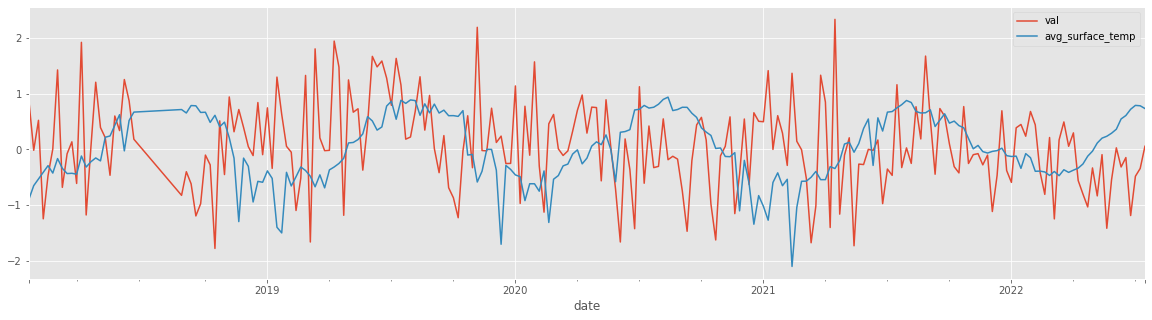

In [5]:
from sklearn.preprocessing import RobustScaler
df_scaled_data = pd.DataFrame( columns=data.columns, data=RobustScaler().fit_transform(data), index=data.index )
_ = df_scaled_data.plot(figsize=(20, 5))

#### Find significant lags of sea surface temp for chlorophyll levels.

In [139]:
n_lags = 4
lag_names = [f"lag_{i}" for i in range(1,n_lags+1)]

df_sea_temp_lags = pd.concat([data.bfill(), make_lags(surface_temp.avg_surface_temp, lags=n_lags)], axis=1)
df_sea_temp_lags.head()

ols_formula = ("val ~ avg_surface_temp + ") + (" + ".join(lag_names))
lrmodel = smf.ols(ols_formula, data=df_sea_temp_lags).fit()
lrmodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    val   R-squared:                       0.045
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     2.155
Date:                Tue, 02 Aug 2022   Prob (F-statistic):             0.0599
Time:                        08:46:58   Log-Likelihood:                 36.725
No. Observations:                 235   AIC:                            -61.45
Df Residuals:                     229   BIC:                            -40.69
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.0514      0.146     -0.351      0.726      -0.340       0.237
avg_surface_temp    -0.0224      0.010     -2.287      0.023      -0.042      -0.003
lag_1                0.0027      0.011      0.242      0.809      -0.019       0.025
lag_2                0.0007      0.011      0.061      0.951      -0.021       0.022
lag_3               -0.0071      0.011     -0.641      0.522      -0.029       0.015
lag_4                0.0197      0.010      2.017      0.045       0.000       0.039
==============================================================================
Omnibus:                        2.042   Durbin-Watson:                   1.807
Prob(Omnibus):                  0.360   Jarque-Bera (JB):                1.918
Skew:                           0.221   Prob(JB):                        0.383
Kurtosis:                       3.001   Cond. No.                         631.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

 Errors have mean 0.0


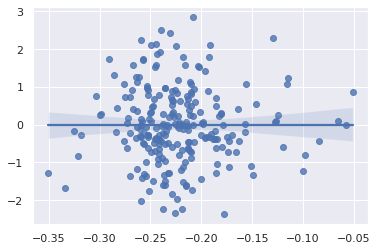

In [141]:
_ = sb.regplot(y=standardize_residuals(lrmodel.resid), x=lrmodel.fittedvalues)
print(f" Errors have mean {np.mean(standardize_residuals(lrmodel.resid))}" )


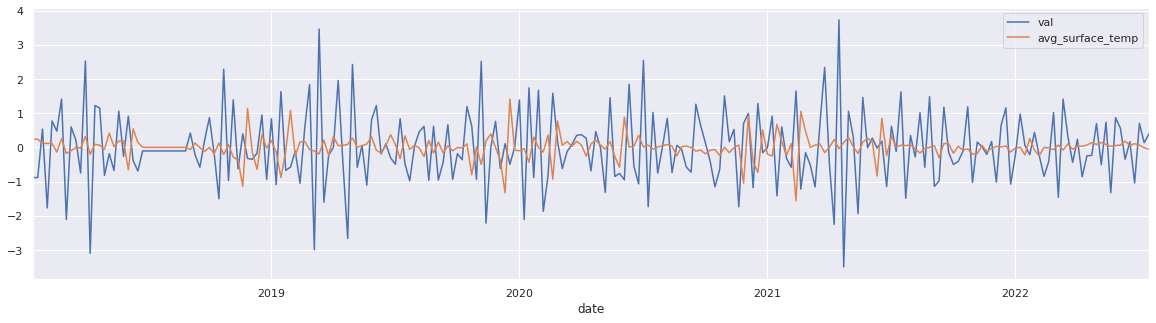

In [146]:
_ = df_scaled_data.diff(1).bfill().plot(figsize=(20, 5))

In [9]:
#exog = [[x] for x in scaled.avg_surface_temp]
test_size = 6
y_train, y_test = pm.model_selection.train_test_split(data.val, test_size=test_size)
y_test

date
2022-06-12   -0.3212
2022-06-19   -0.2762
2022-06-26   -0.5531
2022-07-03   -0.3654
2022-07-10   -0.3283
2022-07-17   -0.2222
Name: val, dtype: float64

[0.346, 0.384] []


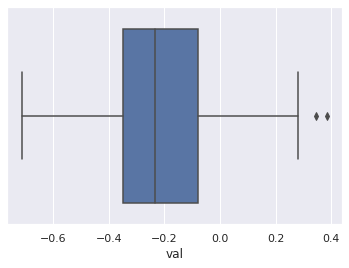

In [116]:
possible, probable = get_outliers(y_train)
print(possible, probable)
_ = sb.boxplot(x=y_train)

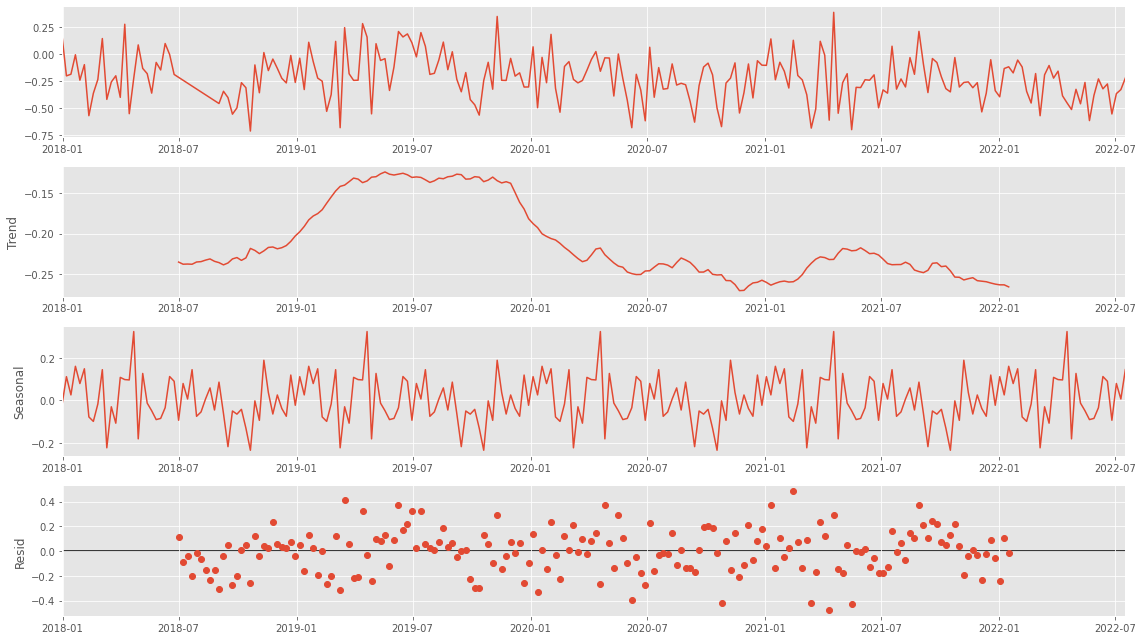

In [12]:
fig: Figure = seasonal_decompose(x=chlorophyll, model='additive').plot()
fig.set_size_inches((16, 9))
fig.tight_layout()
plt.show()

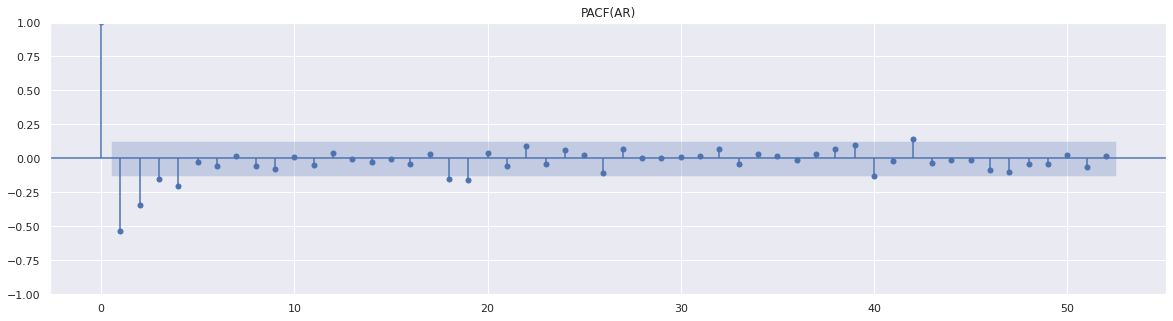

In [55]:
pacf = plot_pacf(chlorophyll.diff(1).bfill(), method='ywm', lags=52, title='PACF(AR)')
pacf.set_figheight(5)
pacf.set_figwidth(20)
pacf.show()
# AR = [1-4], S[1]

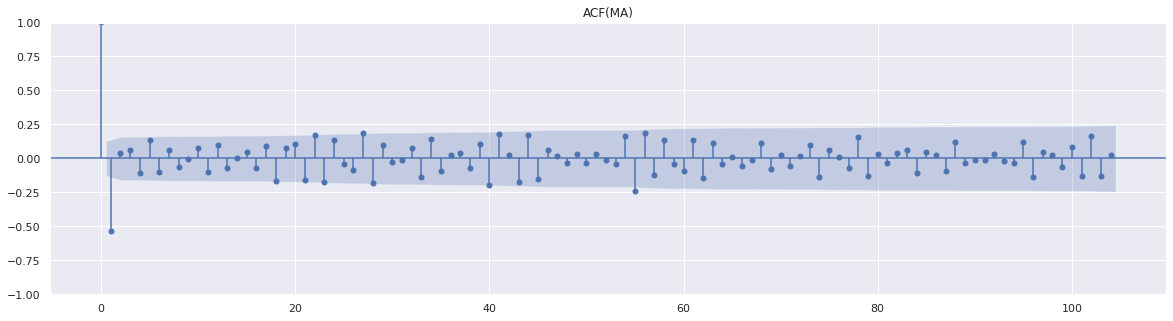

In [77]:
acf: Figure = plot_acf(x=chlorophyll.diff(1).bfill(), lags=104, title='ACF(MA)')
acf.set_figheight(5)
acf.set_figwidth(20)
acf.show()
# MA = 1

In [109]:
arima_args = {
'y': y_train,

'start_p': 0, 'max_p': 4,
'd': 1,
#'start_d': 1, 'max_d': 2,
'start_q': 0, 'max_q': 4,

'start_P': 0, 'max_P': 4,
'D': 1,
#'start_D': 0, 'max_D': 1,
'start_Q': 0, 'max_Q': 4,
'seasonal': True, 'm': 52,

'trace': True,
'error_action': 'ignore',
'suppress_warnings': True,
'stepwise': True,
'information_criterion': 'bic'
}

stepwise_model = get_model(path=f'{os.getcwd()}/models/chlorophyll_stepwise.pkl', args=arima_args, write_blob=True)

In [110]:
stepwise_model.fit(y_train)

ARIMA(order=(2, 1, 0), scoring_args={}, seasonal_order=(2, 1, 1, 52),
      suppress_warnings=True, with_intercept=False)

In [111]:
stepwise_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  229
Model:             SARIMAX(2, 1, 0)x(2, 1, [1], 52)   Log Likelihood                 -16.726
Date:                              Tue, 02 Aug 2022   AIC                             45.451
Time:                                      08:05:54   BIC                             64.474
Sample:                                           0   HQIC                            53.167
                                              - 229                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7596      0.071    -10.674      0.000      -0.899      -0.620
ar.L2         -0.4359      0.061     -7.150      0.000      -0.555      -0.316
ar.S.L52      -0.4197      0.351     -1.197      0.231      -1.107       0.267
ar.S.L104     -0.3296      0.201     -1.638      0.101      -0.724       0.065
ma.S.L52      -0.5067      0.584     -0.868      0.386      -1.651       0.638
sigma2         0.0504      0.012      4.294      0.000       0.027       0.073
===================================================================================
Ljung-Box (L1) (Q):                   0.88   Jarque-Bera (JB):                 5.52
Prob(Q):                              0.35   Prob(JB):                         0.06
Heteroskedasticity (H):               0.74   Skew:                            -0.14
Prob(H) (two-sided):                  0.25   Kurtosis:                         3.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

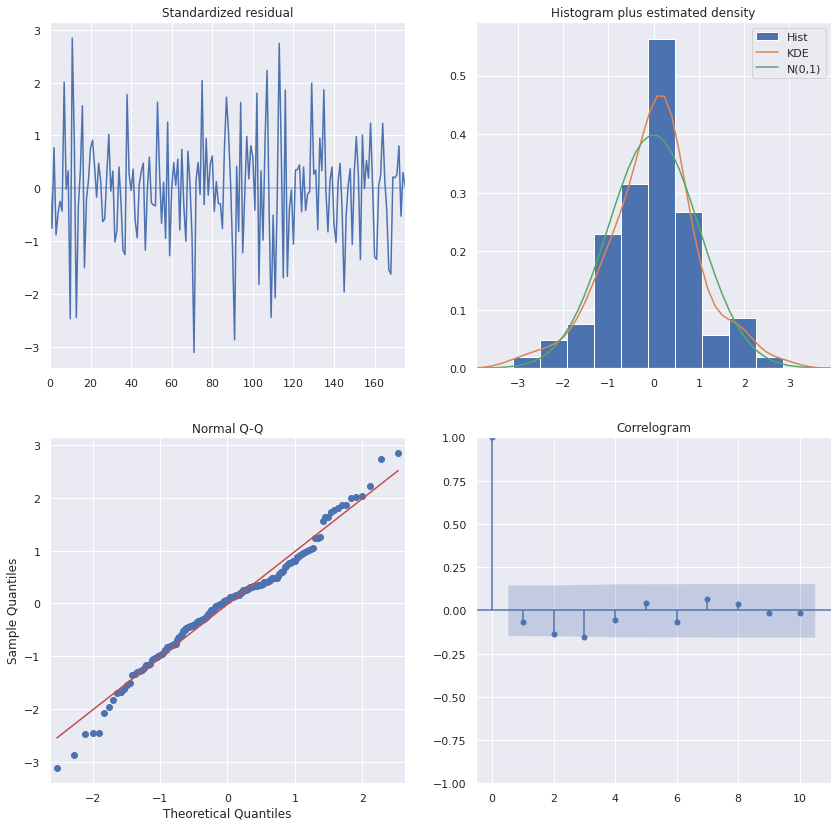

In [112]:
_ = stepwise_model.plot_diagnostics(figsize=(14, 14))

,Yhat,Actual,Error,PercError
0,-0.253760,-0.3212,0.067440,-0.209963
1,-0.246540,-0.2762,0.029660,-0.107385
2,-0.394359,-0.5531,0.158741,-0.287003
3,-0.322251,-0.3654,0.043149,-0.118088
4,-0.303888,-0.3283,0.024412,-0.074358
5,-0.272128,-0.2222,0.049928,-0.224698


MAE: 0.062, MAPE: -17.02%


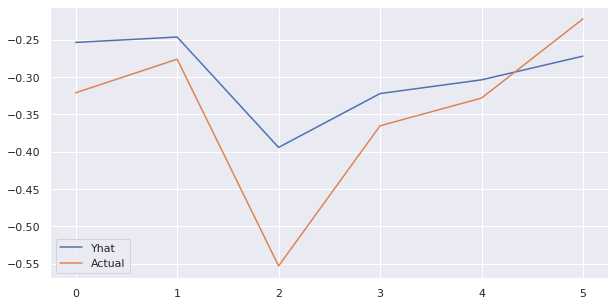

In [113]:
evaluate_test_fit(stepwise_model, y_test)

/tmp/ipykernel_373/3548260000.py:84: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


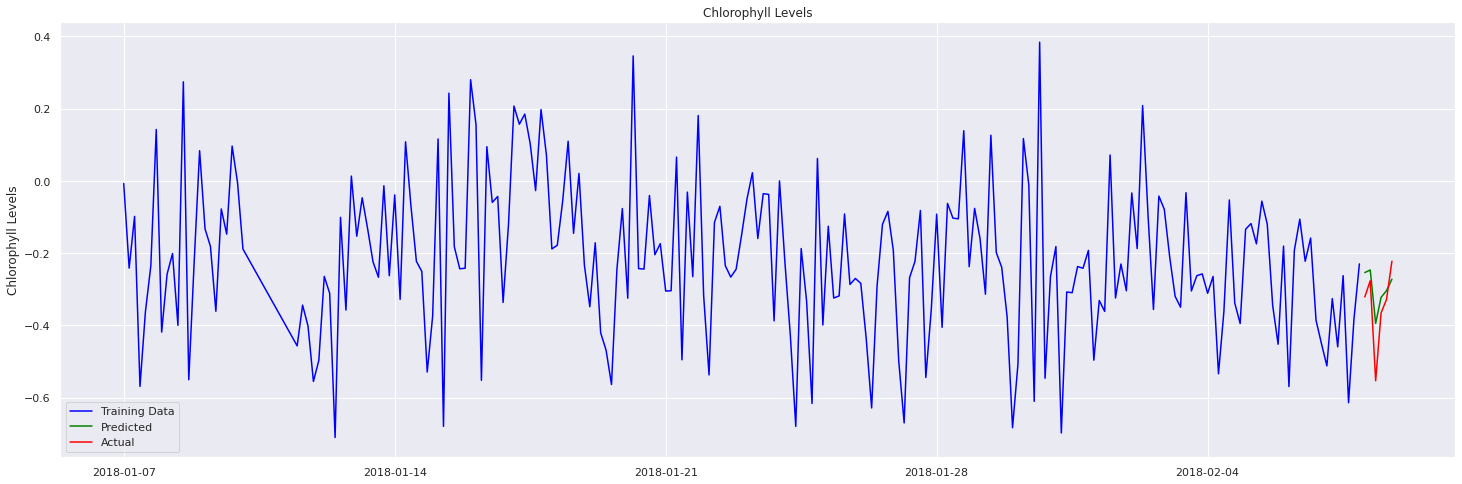

In [114]:
xticklabels = list(map(lambda d: str(d).split('T')[0], chlorophyll.index.values))
plot_forecast(model=stepwise_model, y_train=y_train, y_test=y_test, xticklabels=xticklabels)

### Model Sea Surface Temp

[16.4664] []


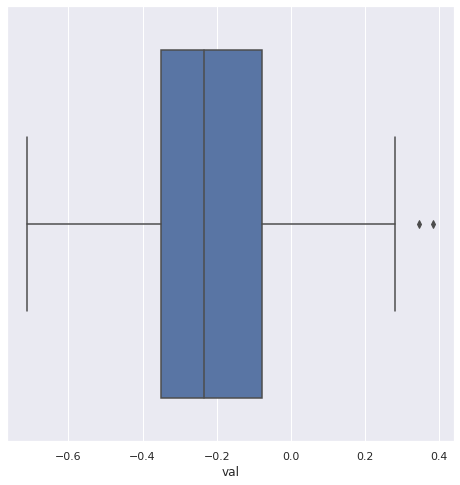

In [243]:
#surface_temp['ln_temp'] = np.log(surface_temp.avg_surface_temp)
surface_temp['month'] = surface_temp.index.month.astype('int')

surface_temp_y_train, surface_temp_y_test = pm.model_selection.train_test_split(surface_temp.avg_surface_temp, test_size=test_size)
surface_temp_X_train, surface_temp_X_test = pm.model_selection.train_test_split(surface_temp.month, test_size=test_size)
surface_temp_X_train = [[x] for x in surface_temp_X_train]
surface_temp_X_test = [[x] for x in surface_temp_X_test]

possible, probable = get_outliers(surface_temp_y_train)
print(possible, probable)
_ = sb.boxplot(x=y_train)

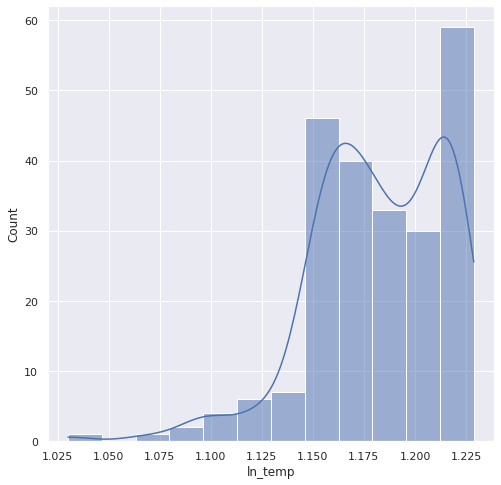

In [217]:
_ = sb.histplot(x= np.log(surface_temp_y_train), kde=True)

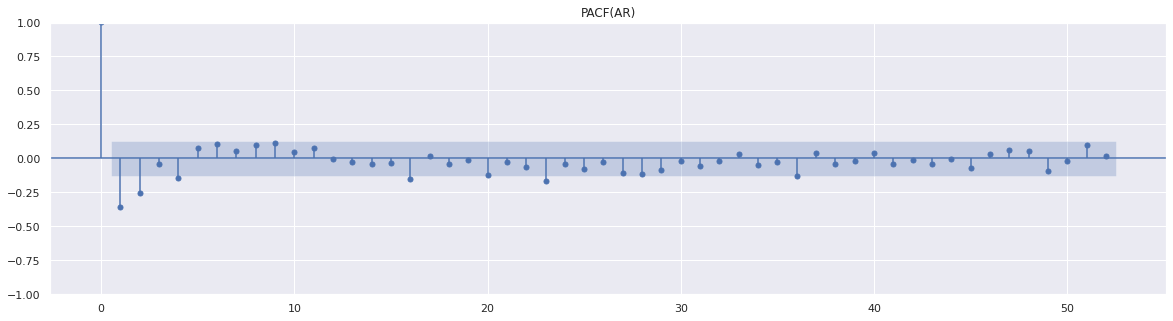

In [225]:
pacf: Figure = plot_pacf(x=surface_temp_y_train.diff().bfill(), method='ywm', lags=52, title='PACF(AR)')
pacf.set_figheight(5)
pacf.set_figwidth(20)
pacf.show()
AR = [1-2]

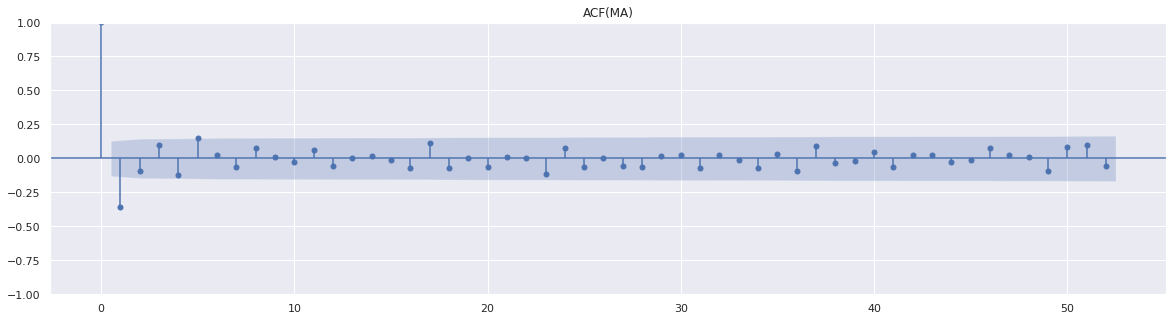

In [226]:
acf: Figure = plot_acf(x=surface_temp_y_train.diff().bfill(), lags=52, title='ACF(MA)')
acf.set_figheight(5)
acf.set_figwidth(20)
acf.show()
# MA [1-5]

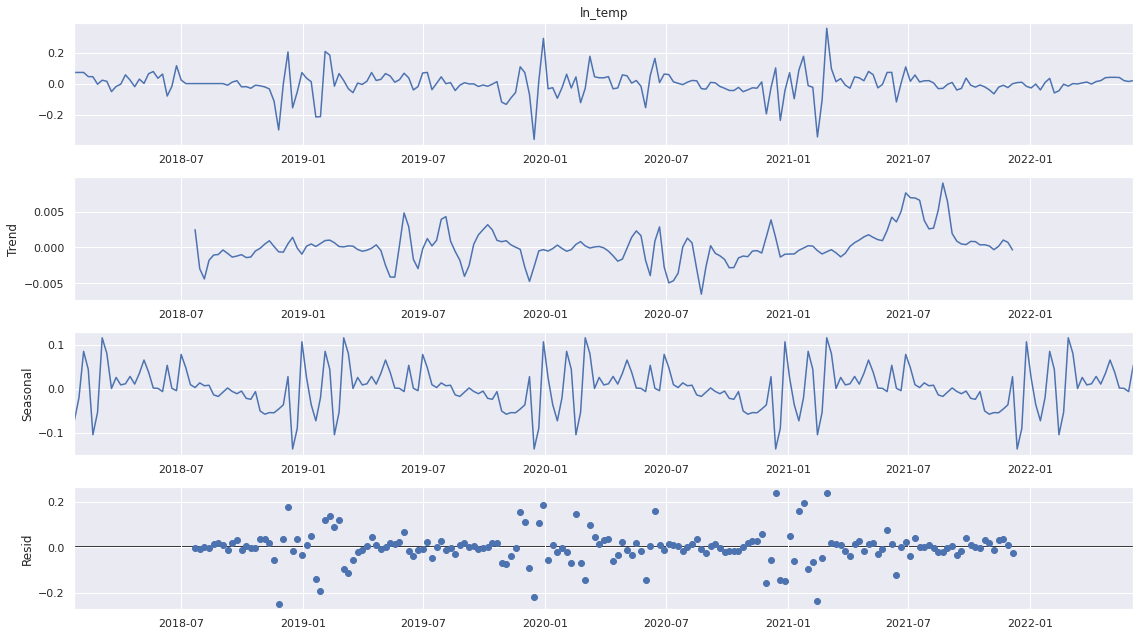

In [228]:
fig: Figure = seasonal_decompose(x=surface_temp_y_train.diff(2).bfill()).plot()
fig.set_size_inches((16, 9))
fig.tight_layout()
plt.show()

In [260]:

sea_surface_arima_args = {
'y': surface_temp_y_train,
'X': surface_temp_X_train,
'start_p': 0, 'max_p': 4,
#'d': 1,
'start_d': 0, 'max_d': 2,
'start_q': 0, 'max_q': 4,

'seasonal': False, 'm': 52,
'start_P': 0, 'max_P': 2,
'D': 0,
'start_D': 0, 'max_D': 1,
'start_Q': 0, 'max_Q': 2,

'trace': True,
'error_action': 'ignore',
'suppress_warnings': True,
'stepwise': True,
'information_criterion': 'aic'
}

sea_temp_stepwise = get_model(f'{os.getcwd()}/models/surface_temp_stepwise_v2.pkl', sea_surface_arima_args, write_blob=True)

/home/jbonfardeci/miniconda3/lib/python3.9/site-packages/pmdarima/arima/_validation.py:62: UserWarning: m (52) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1790.265, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1599.570, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=829.682, Time=0.12 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=831.677, Time=0.27 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=831.674, Time=0.16 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=1494.301, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=830.561, Time=0.24 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=820.569, Time=0.14 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=948.989, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=844.070, Time=0.17 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=822.566, Time=0.28 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=822.564, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1067.597, 

In [261]:
sea_temp_stepwise.fit(y=surface_temp_y_train, X=surface_temp_X_train)

ARIMA(order=(1, 0, 1), scoring_args={}, suppress_warnings=True)

In [262]:
sea_temp_stepwise.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  229
Model:               SARIMAX(1, 0, 1)   Log Likelihood                -405.284
Date:                Tue, 02 Aug 2022   AIC                            820.569
Time:                        18:29:32   BIC                            837.737
Sample:                             0   HQIC                           827.495
                                - 229                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.5551      0.856      1.817      0.069      -0.122       3.233
x1             0.0737      0.088      0.843      0.399      -0.098       0.245
ar.L1          0.9394      0.034     27.373      0.000       0.872       1.007
ma.L1         -0.4124      0.063     -6.577      0.000      -0.535      -0.289
sigma2         2.0054      0.114     17.566      0.000       1.782       2.229
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               629.33
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               0.81   Skew:                            -1.97
Prob(H) (two-sided):                  0.36   Kurtosis:                        10.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

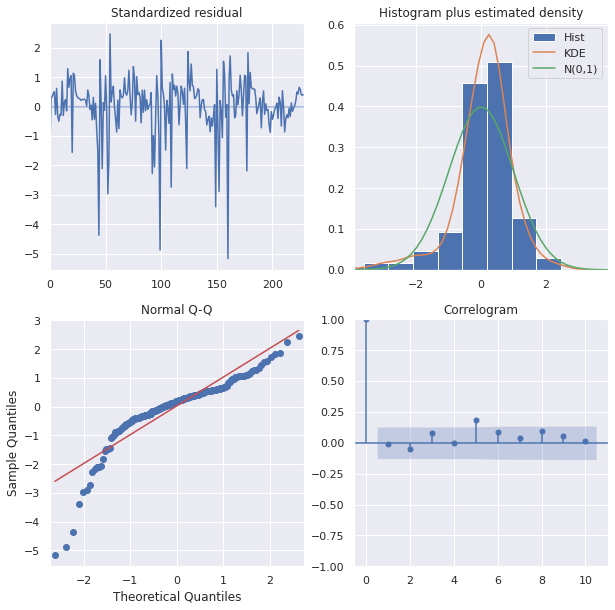

In [263]:
_ = sea_temp_stepwise.plot_diagnostics(figsize=(10, 10))

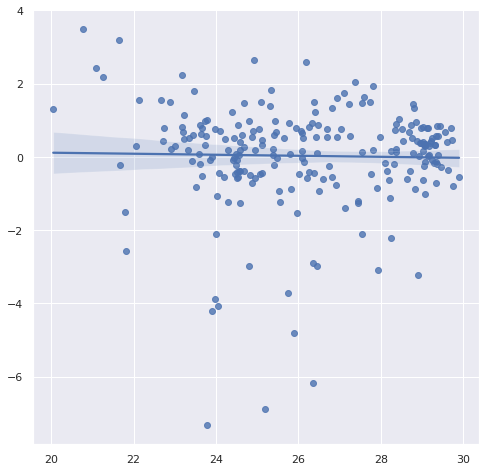

In [264]:
sb.set(rc={"figure.figsize":(8, 8)})
_ = sb.regplot(y=sea_temp_stepwise.resid(), x=sea_temp_stepwise.arima_res_.fittedvalues)

,Yhat,Actual,Error,PercError
0,27.485504,28.6770,1.191496,0.041549
1,27.402707,28.9600,1.557293,0.053774
2,27.324925,29.4778,2.152875,0.073034
3,27.325599,29.7985,2.472901,0.082987
4,27.256954,29.7662,2.509246,0.084298
5,27.192467,29.5390,2.346533,0.079438


MAE: 2.038, MAPE: 6.92%


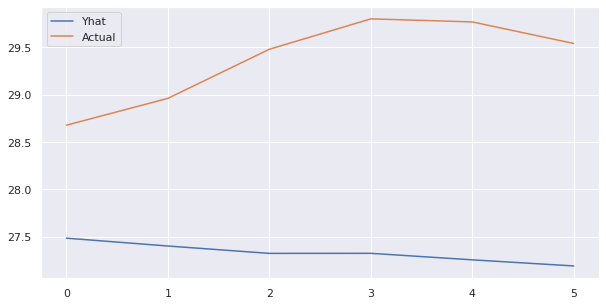

In [266]:
evaluate_test_fit(sea_temp_stepwise, surface_temp_y_test, X=surface_temp_X_test)

In [268]:
exog_train, exog_test = pm.model_selection.train_test_split(surface_temp[['avg_surface_temp', 'month']].values.tolist(), test_size=6)
arima_args['y'] = y_train
arima_args['X'] = exog_train
combined_model = get_model(f'{os.getcwd()}/models/combined_stepwise_v2.pkl', arima_args, write_blob=False)

Performing stepwise search to minimize bic
 ARIMA(0,1,0)(0,1,0)[52]             : BIC=212.158, Time=0.57 sec
 ARIMA(1,1,0)(1,1,0)[52]             : BIC=109.206, Time=4.38 sec
 ARIMA(0,1,1)(0,1,1)[52]             : BIC=inf, Time=8.68 sec
 ARIMA(1,1,0)(0,1,0)[52]             : BIC=159.886, Time=0.56 sec
 ARIMA(1,1,0)(2,1,0)[52]             : BIC=inf, Time=10.35 sec
 ARIMA(1,1,0)(1,1,1)[52]             : BIC=inf, Time=8.39 sec
 ARIMA(1,1,0)(0,1,1)[52]             : BIC=inf, Time=6.60 sec
 ARIMA(1,1,0)(2,1,1)[52]             : BIC=inf, Time=25.61 sec
 ARIMA(0,1,0)(1,1,0)[52]             : BIC=160.537, Time=2.22 sec
 ARIMA(2,1,0)(1,1,0)[52]             : BIC=75.636, Time=5.15 sec
 ARIMA(2,1,0)(0,1,0)[52]             : BIC=118.416, Time=0.70 sec
 ARIMA(2,1,0)(2,1,0)[52]             : BIC=inf, Time=12.69 sec
 ARIMA(2,1,0)(1,1,1)[52]             : BIC=inf, Time=12.85 sec
 ARIMA(2,1,0)(0,1,1)[52]             : BIC=inf, Time=12.42 sec
 ARIMA(2,1,0)(2,1,1)[52]             : BIC=65.463, Time=25.89

In [269]:
combined_model.fit(y=y_train, X=exog_train)
combined_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  229
Model:             SARIMAX(2, 1, 0)x(2, 1, [1], 52)   Log Likelihood                 -12.050
Date:                              Tue, 02 Aug 2022   AIC                             40.099
Time:                                      18:42:10   BIC                             65.463
Sample:                                           0   HQIC                            50.387
                                              - 229                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0328      0.013     -2.452      0.014      -0.059      -0.007
x2             0.0737      0.057      1.286      0.199      -0.039       0.186
ar.L1         -0.7655      0.070    -10.890      0.000      -0.903      -0.628
ar.L2         -0.4530      0.058     -7.781      0.000      -0.567      -0.339
ar.S.L52      -0.4687      0.394     -1.190      0.234      -1.240       0.303
ar.S.L104     -0.3319      0.218     -1.526      0.127      -0.758       0.094
ma.S.L52      -0.4232      0.608     -0.696      0.486      -1.614       0.768
sigma2         0.0495      0.010      5.022      0.000       0.030       0.069
===================================================================================
Ljung-Box (L1) (Q):                   1.22   Jarque-Bera (JB):                 5.89
Prob(Q):                              0.27   Prob(JB):                         0.05
Heteroskedasticity (H):               0.86   Skew:                            -0.12
Prob(H) (two-sided):                  0.58   Kurtosis:                         3.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

,Yhat,Actual,Error,PercError
0,-0.277113,-0.3212,0.044087,-0.137256
1,-0.233256,-0.2762,0.042944,-0.155482
2,-0.401217,-0.5531,0.151883,-0.274603
3,-0.288609,-0.3654,0.076791,-0.210156
4,-0.296964,-0.3283,0.031336,-0.095451
5,-0.221580,-0.2222,0.000620,-0.002790


MAE: 0.058, MAPE: -14.6%


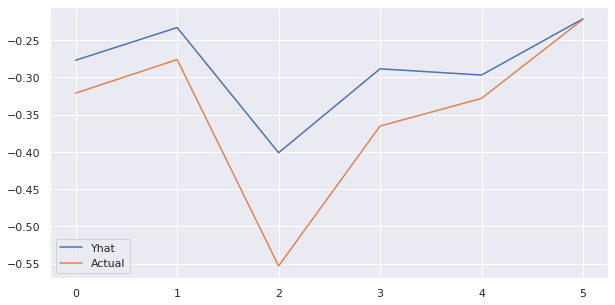

In [282]:
final_exog_test = [[x,y[0]] for x,y in zip(surface_temp_y_test, surface_temp_X_test)]
evaluate_test_fit(model=combined_model, y_test=y_test, X=final_exog_test)

/tmp/ipykernel_373/1780079826.py:88: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


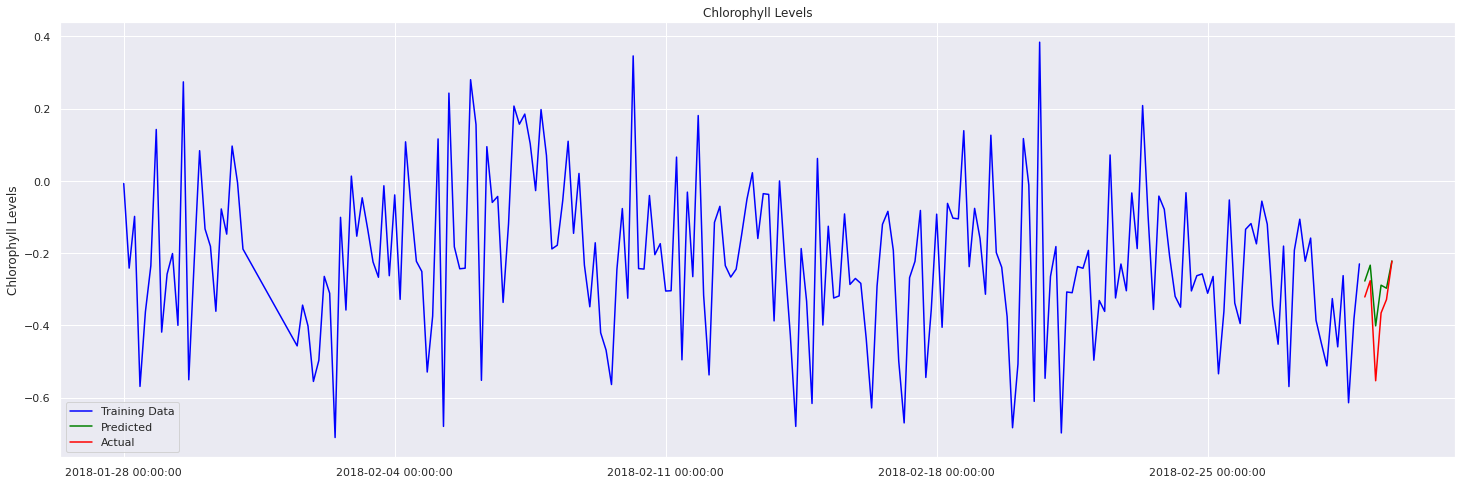

In [283]:
xticklabels = list(map(lambda d: str(d).split('T')[0], surface_temp.index))
plot_forecast(model=combined_model, y_train=y_train, y_test=y_test, X=final_exog_test, xticklabels=xticklabels)

In [34]:
#test_dates = scaled.index.values[len(scaled)-len(y_test):]
future_weeks = np.array([
    '2022-07-24',
    '2022-07-31',
    '2022-08-07',
    '2022-08-14',
    '2022-08-21',
    '2022-08-28',
    '2022-09-04',
    '2022-09-11',
    '2022-09-18',
    '2022-09-25',
    '2022-10-02',
    '2022-10-09'
], dtype='datetime64[ns]')
future_weeks = pd.to_datetime(future_weeks)
future_weeks.freq = 'w'

predictions = stepwise_model.predict(n_periods=len(future_weeks))
df_forecast = pd.DataFrame(columns=['date', 'yhat', 'actual'], data=[[d, yhat, np.NaN] for d, yhat in zip(future_weeks, predictions)])